In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold,StratifiedKFold
import sys
from pylab import *  
mpl.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False

In [40]:
import matplotlib.pyplot as plt
import pickle

# Define the figure size and arrow format, program 3_5
decisionNode = dict(boxstyle="sawtooth", fc = "0.8")
leafNode = dict(boxstyle="round4", fc = "0.8")
arrow_args = dict(arrowstyle = "<-")

# Draw comment with arrows
def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy = parentPt, \
    xycoords = 'axes fraction', xytext = centerPt, \
    textcoords = 'axes fraction', \
    va = "center", ha = "center", bbox = nodeType, \
    arrowprops = arrow_args)

def createPlot():
    fig = plt.figure(1, facecolor = 'white')
    fig.clf()
    createPlot.ax1 = plt.subplot(111, frameon = False)
    plotNode('Decision Node', (0.5, 0.1), (0.1, 0.5), decisionNode)
    plotNode('Branch Node', (0.8, 0.1), (0.3, 0.8), leafNode)
    plt.show()

# Number of leafs of tree, program 3_6
def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    # Testing whether the data type in node is dict
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs += 1
    return numLeafs

def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        if thisDepth > maxDepth:
            maxDepth = thisDepth
    return maxDepth

def retrieveTree(i):
    listOfTrees = [{'no surfacing': {0: 'no', 1: {'flippers': \
                    {0: 'no', 1: 'yes'}}}},
                   {'no surfacing': {0: 'no', 1: {'flippers': \
                    {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}
                   ]
    return listOfTrees[i]

# Fill text message in father nodes, program 3_7
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0] - cntrPt[0]) / 2.0 + cntrPt[0]
    yMid = (parentPt[1] - cntrPt[1]) / 2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString)

# Calculate the height and width
def plotTree(myTree, parentPt, nodeTxt):
    numLeafs = getNumLeafs(myTree)
    depth = getTreeDepth(myTree)
    firstStr = list(myTree.keys())[0]
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs)) / 2.0 / plotTree.totalW, \
                plotTree.yOff)
    # Mark the child node text
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    # Reduce the shift value of y axis
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__== 'dict':
            plotTree(secondDict[key], cntrPt, str(key))
        else:
            plotTree.xOff = plotTree.xOff + 1.0 / plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), \
                cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0 / plotTree.totalD

def createPlot(inTree):
    fig = plt.figure(1, facecolor = 'white')
    fig.clf()
    axprops = dict(xticks = [], yticks = [])
    createPlot.ax1 = plt.subplot(111, frameon = False, **axprops)
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5 / plotTree.totalW
    plotTree.yOff = 1.0
    plotTree(inTree, (0.5, 1.0), '')
    plt.show()

In [67]:
class decisionTree:
    def __init__(self,args):
        self.args=args
    
    # ctns stands for continue columns, while dsct stands for discrete columns
    def train(self,train_df,val_df,ctns,dsct):
        train=train_df.copy()
        
        self.args['ctns']=ctns
        self.args['dsct']=dsct
        
        self.args['dsctDct']={}
        for col in dsct:
            self.args['dsctDct'][col]=train[col].value_counts()
   
        self.args['categories']=train.iloc[:,-1].value_counts()
        self.args['val']=val_df.copy()
        self.args['tree']=self.treeGenerate(train,train.columns[:-1].values.tolist())
        
        if self.args['postPruning']==True:
            self.args['tree']=self.postPruning(self.args['tree'])
            
        return self.args['tree']
    
    # check if cur dataset are all in same categories
    def isSameClass(self,X):
        if X.iloc[:,-1].is_unique:
            return X.iloc[0,-1]
        else:
            return False
        
    # check if cur dataset are all in a same 
    def isSameAttr(self,X,attrs):
        res=True
        for col in attrs:
            res=res and X.loc[:,col].is_unique
        return res
    
    def mostCommonClass(self,X):
        classDct=X.iloc[:,-1].value_counts()
        return classDct.index[0]
    
    def entropy(self,X):
        classDct=X.iloc[:,-1].value_counts()
        pClassDct=classDct.divide(classDct.sum())
        ent=0.0
        
        for className in pClassDct.index:
            if pClassDct[className]!=0:
                ent+=pClassDct[className]*np.log2(pClassDct[className])
        
        return ent
    
    def gini(self,X):
        classDct=X.iloc[:,-1].value_counts()
        pClassDct=classDct.divide(classDct.sum())
        gini=0.0
        for value in pClassDct.values:
            gini+=value*value
        return 1-gini
    
    # breadth first recursion
    def postPruning(self,root):
        if isinstance(root,str):
            return root
        
        curNode=next(iter(root))
        for key in root[curNode].keys():
            root[curNode][key]=self.postPruning(root[curNode][key])
        
        bfCorrect=0
        afCorrect=0
        bfCommon=self.mostCommonClass(self.args['val'])
        
        for _,row in self.args['val'].iterrows():
            if row[-1]==bfCommon:
                bfCorrect+=1
            if row[-1]==self.forward(row,root):
                afCorrect+=1
        
        if bfCorrect>=afCorrect:
            return bfCommon
        
        return root
        
        
        
    def prePruning(self,X,best_a,best_t):
        sub_nodes={best_a:{}}
                            
        if best_a in self.args['dsct']:
            for dsctValue in self.args['dsctDct'][best_a].index:
                tempX=X[X[best_a]==dsctValue].copy()
                
                if tempX.empty:
                    sub_nodes[best_a][dsctValue]=self.args['categories'].index[0]
                else:
                    sub_nodes[best_a][dsctValue]=self.mostCommonClass(tempX)
        
        elif best_a in self.args['ctns']:
            
            tempHiX=X.loc[X[best_a]>best_t]
            tempLoX=X.loc[X[best_a]<=best_t]
            
            if tempHiX.empty:
                sub_nodes[best_a]['>'+str(best_t)]=self.args['categories'].index[0]
            else:
                sub_nodes[best_a]['>'+str(best_t)]=self.mostCommonClass(tempHiX)
                    
            if tempLoX.empty:
                sub_nodes[best_a]['<='+str(best_t)]=self.args['categories'].index[0]
            else:
                sub_nodes[best_a]['<='+str(best_t)]=self.mostCommonClass(tempLoX)
    
        # bf stands for before, while af stands for after
        
        bfCommon=self.mostCommonClass(X)
        bfCorrect=0
        
        afCorrect=0
        
        for index,row in self.args['val'].iterrows():
            if row[-1]==bfCommon:
                bfCorrect+=1
            if row[-1]==self.forward(row,sub_nodes):
                afCorrect+=1
        
        if bfCorrect>=afCorrect:
            return bfCommon
        
        return False
    
    # Given a sample and decision tree, return the categories
    def forward(self,x,tree):
        if isinstance(tree,str):
            return tree
        
        first_key=next(iter(tree))
        
        if first_key in self.args['dsct']:
            for attr in tree[first_key].keys():
                if x[first_key]==attr:
                    return self.forward(x,tree[first_key][attr])
        elif first_key in self.args['ctns']:
            for key in tree[first_key].keys():
                if '>' in key:
                    hiKey=key
                elif '<=' in key:
                    loKey=key
            
            t=float(hiKey.split('>')[-1])
            if x[first_key]<=t:
                return self.forward(x,tree[first_key][loKey])
            return self.forward(x,tree[first_key][hiKey])
        
        
    # choose attr w/ least score
    def bestAttr(self,X,attrs):
        globaMinScore=float('inf')
        best_a,best_t=None,None
        
        for a in attrs:
            temp_t=None
            minScore=float('inf')
            
            if a in self.args['dsct']:
                subScore=0.0
                for dsctValue in self.args['dsctDct'][a].index:
                    tempX=X[X[a]==dsctValue]
                    
                    if self.args['method']=='info_gain':
                        subScore+=(tempX.shape[0]/X.shape[0])*self.entropy(tempX)
                    elif self.args['method']=='gini':
                        subScore+=(tempX.shape[0]/X.shape[0])*self.gini(tempX)
                    
                    
                minScore=subScore
                
            elif a in self.args['ctns']:
                tempCol=X[a].drop_duplicates().sort_values()
                
                if tempCol.size!=1:
                    tempT=[(tempCol.iloc[i]+tempCol.iloc[i+1])/2\
                           for i in range(tempCol.size-1)]
                else:
                    tempT=tempCol.tolist()
                
                for t in tempT:
                    subScore=0.0
                    tempHiX=X[X[a]>t]
                    tempLoX=X[X[a]<=t]
                    
                    if self.args['method']=='info_gain':
                        subScore=(tempHiX.shape[0]/X.shape[0])*self.entropy(tempHiX)\
                              +(tempLoX.shape[0]/X.shape[0])*self.entropy(tempLoX)
                    elif self.args['method']=='gini':
                        subScore=(tempHiX.shape[0]/X.shape[0])*self.gini(tempHiX)\
                              +(tempLoX.shape[0]/X.shape[0])*self.gini(tempLoX)
                    
                    if subScore<minScore:
                        minScore=subScore
                        temp_t=t
                                
            if minScore<globaMinScore:
                globalMinScore,best_a,best_t=minScore,a,temp_t
        
        return best_a,best_t
    
    def predict(self,test):
        total=test.shape[0]
        correct=0
        for _,row in test.iterrows():
            if self.forward(row,self.args['tree'])==row[-1]:
                correct+=1
        print("---\nTotal: ",total)
        print("Correct: ",correct)
        print("Accuracy: ",correct/total)
    
    # recursive treeGenerate to generate the tree
    def treeGenerate(self,X,attrs):
        # if all are same class
        sameClass=self.isSameClass(X)
        if sameClass is not False:
            return sameClass
        
        if len(attrs)==0 or self.isSameAttr(X,attrs):
            return self.mostCommonClass(X)
        
        best_a,best_t=self.bestAttr(X,attrs)
        
        if self.args['prePruning']==True:
            isPruning=self.prePruning(X,best_a,best_t)
            if isPruning!=False:
                return isPruning
            
        sub_nodes={best_a:{}}
        attrs.remove(best_a)
#         print(sub_nodes)             
        if best_a in self.args['dsct']:
            for dsctValue in self.args['dsctDct'][best_a].index:
                tempX=X[X[best_a]==dsctValue].copy()
                
                if tempX.empty:
                    sub_nodes[best_a][dsctValue]=self.args['categories'].index[0]
                else:
                    sub_nodes[best_a][dsctValue]=self.treeGenerate(tempX,attrs)
        
        elif best_a in self.args['ctns']:
            
            tempHiX=X.loc[X[best_a]>best_t]
            tempLoX=X.loc[X[best_a]<=best_t]
            
            if tempHiX.empty:
                sub_nodes[best_a]['>'+str(round(best_t,2))]=self.args['categories'].index[0]
            else:
                sub_nodes[best_a]['>'+str(round(best_t,2))]=self.treeGenerate(tempHiX,attrs)
                    
            if tempLoX.empty:
                sub_nodes[best_a]['<='+str(round(best_t,2))]=self.args['categories'].index[0]
            else:
                sub_nodes[best_a]['<='+str(round(best_t,2))]=self.treeGenerate(tempLoX,attrs)        
        return sub_nodes
        

In [89]:
def readWaterMelon():
    df=pd.read_csv('watermelon3.csv',delimiter=',')
    df.iloc[:,-1] = pd.Categorical(df.iloc[:,-1])
    df['code'] = df.iloc[:,-1].cat.codes
    df['code']=df['code'].astype(str)
    df=df.drop([df.columns[0],df.columns[-2]],axis=1)
    
    sfolder = StratifiedKFold(n_splits=4,random_state=0)
    sfolder.get_n_splits(df)
    train_index, test_index=next(sfolder.split(df,df.iloc[:,-1].values))
    train_df,val_df=df.iloc[train_index],df.iloc[test_index]
    
    dsct=[]
    ctns=[]
    for col in df.columns[:-1]:
        if df[col].dtype=='object':
            dsct.append(col)
        else:
            ctns.append(col)
    
    return train_df,val_df,dsct,ctns

def readWaterMelon2():
    df=pd.read_csv('wm2train.csv',delimiter=',')
    df.iloc[:,-1] = pd.Categorical(df.iloc[:,-1])
    df['code'] = df.iloc[:,-1].cat.codes
    df['code']=df['code'].astype(str)
    df=df.drop([df.columns[0],df.columns[-2]],axis=1)
    
    dsct=[]
    ctns=[]
    for col in df.columns[:-1]:
        if df[col].dtype=='object':
            dsct.append(col)
        else:
            ctns.append(col)
    
    train_df=df.copy()
    
    df=pd.read_csv('wm2val.csv',delimiter=',')
    df.iloc[:,-1] = pd.Categorical(df.iloc[:,-1])
    df['code'] = df.iloc[:,-1].cat.codes
    df['code']=df['code'].astype(str)
    df=df.drop([df.columns[0],df.columns[-2]],axis=1)
    
    dsct=[]
    ctns=[]
    for col in df.columns[:-1]:
        if df[col].dtype=='object':
            dsct.append(col)
        else:
            ctns.append(col)
    
    val_df=df.copy()
    
    return train_df,val_df,dsct,ctns


(   色泽  根蒂  敲声  纹理  脐部  触感 code
 0  青绿  蜷缩  浊响  清晰  凹陷  硬滑    1
 1  乌黑  蜷缩  沉闷  清晰  凹陷  硬滑    1
 2  乌黑  蜷缩  浊响  清晰  凹陷  硬滑    1
 3  青绿  稍蜷  浊响  清晰  稍凹  软粘    1
 4  乌黑  稍蜷  浊响  稍糊  稍凹  软粘    1
 5  青绿  硬挺  清脆  清晰  平坦  软粘    0
 6  浅白  稍蜷  沉闷  稍糊  凹陷  硬滑    0
 7  乌黑  稍蜷  浊响  清晰  稍凹  软粘    0
 8  浅白  蜷缩  浊响  模糊  平坦  硬滑    0
 9  青绿  蜷缩  沉闷  稍糊  稍凹  硬滑    0,    色泽  根蒂  敲声  纹理  脐部  触感 code
 0  青绿  蜷缩  沉闷  清晰  凹陷  硬滑    1
 1  浅白  蜷缩  浊响  清晰  凹陷  硬滑    1
 2  乌黑  稍蜷  浊响  清晰  稍凹  硬滑    1
 3  乌黑  稍蜷  沉闷  稍糊  稍凹  硬滑    0
 4  浅白  硬挺  清脆  模糊  平坦  硬滑    0
 5  浅白  蜷缩  浊响  模糊  平坦  软粘    0
 6  青绿  稍蜷  浊响  稍糊  凹陷  硬滑    0, ['色泽', '根蒂', '敲声', '纹理', '脐部', '触感'], [])

In [107]:
train_df,val_df,dsct,ctns=readWaterMelon2()

args={
    'val':val_df,
    'prePruning':True,
    'method':'info_gain',
    'postPruning':False,
}
wmTree43=decisionTree(args)
wmTree43Dct=wmTree43.train(train_df,val_df,ctns,dsct)
wmTree43.predict(val_df)
print(wmTree43Dct)
# createPlot(wmTree43Dct)

---
Total:  7
Correct:  3
Accuracy:  0.42857142857142855
1


---
Total:  7
Correct:  5
Accuracy:  0.7142857142857143
{'触感': {'硬滑': {'脐部': {'凹陷': {'纹理': {'清晰': {'敲声': {'浊响': {'根蒂': {'蜷缩': '1', '稍蜷': '1', '硬挺': '1'}}, '沉闷': '1', '清脆': '1'}}, '稍糊': '0', '模糊': '1'}}, '稍凹': '0', '平坦': '0'}}, '软粘': {'色泽': {'青绿': '1', '乌黑': '1', '浅白': '1'}}}}


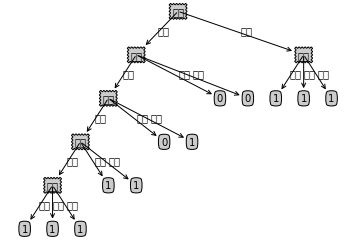

In [90]:
train_df,val_df,dsct,ctns=readWaterMelon2()

args={
    'val':val_df,
    'prePruning':False,
    'method':'gini',
    'postPruning':False,
}
wmTree441=decisionTree(args)
wmTree441Dct=wmTree441.train(train_df,val_df,ctns,dsct)
wmTree441.predict(val_df)
print(wmTree441Dct)
createPlot(wmTree441Dct)

In [93]:
train_df,val_df,dsct,ctns=readWaterMelon2()

args={
    'val':val_df,
    'prePruning':True,
    'method':'gini',
    'postPruning':False,
}
wmTree442=decisionTree(args)
wmTree442Dct=wmTree442.train(train_df,val_df,ctns,dsct)
wmTree442.predict(val_df)
print(wmTree442Dct)
#createPlot(wmTree442Dct)

---
Total:  7
Correct:  3
Accuracy:  0.42857142857142855
1


In [92]:
train_df,val_df,dsct,ctns=readWaterMelon2()

args={
    'val':val_df,
    'prePruning':False,
    'method':'gini',
    'postPruning':True,
}
wmTree443=decisionTree(args)
wmTree443Dct=wmTree443.train(train_df,val_df,ctns,dsct)
wmTree443.predict(val_df)
print(wmTree443Dct)
# createPlot(wmTree443Dct)

---
Total:  7
Correct:  4
Accuracy:  0.5714285714285714
0


In [80]:
def readWine():
    df=pd.read_csv('wine.csv',delimiter=',')
    df.iloc[:,0] = pd.Categorical(df.iloc[:,0])
    df['code'] = df.iloc[:,0].cat.codes
    df['code']=df['code'].astype(str)
    df=df.drop([df.columns[0]],axis=1)
    
    sfolder = StratifiedKFold(n_splits=4,random_state=0)
    sfolder.get_n_splits(df)
    train_index, test_index=next(sfolder.split(df,df.iloc[:,-1].values))
    train_df,val_df=df.iloc[train_index],df.iloc[test_index]
    
    dsct=[]
    ctns=[]
    for col in df.columns[:-1]:
        if df[col].dtype=='object':
            dsct.append(col)
        else:
            ctns.append(col)
    return train_df,val_df,dsct,ctns


---
Total:  45
Correct:  19
Accuracy:  0.4222222222222222
{'Proline': {'>284.0': {'OD': {'>3.91': '0', '<=3.91': {'Hue': {'>1.56': '1', '<=1.56': {'Color.int': {'>1.51': {'Proanth': {'>3.43': '1', '<=3.43': {'Nonflavanoid.phenols': {'>0.62': '1', '<=0.62': {'Flavanoids': {'>3.84': '0', '<=3.84': {'Phenols': {'>3.46': '0', '<=3.46': {'Mg': {'>119.0': {'Acl': {'>20.75': '0', '<=20.75': '0'}}, '<=119.0': {'Ash': {'>2.82': '0', '<=2.82': {'Malic.acid': {'>5.42': '1', '<=5.42': {'Alcohol': {'>11.43': '1', '<=11.43': '1'}}}}}}}}}}}}}}}}, '<=1.51': '1'}}}}}}, '<=284.0': '1'}}


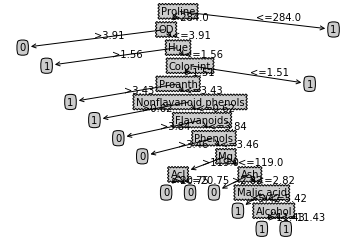

In [81]:
train_df,val_df,dsct,ctns=readWine()
args={
    'val':val_df,
    'prePruning':False,
    'method':'info_gain',
    'postPruning':False,
}
wnTree461=decisionTree(args)
wnTree461Dct=wnTree461.train(train_df,val_df,ctns,dsct)
wnTree461.predict(val_df)
print(wnTree461Dct)
createPlot(wnTree461Dct)

---
Total:  45
Correct:  18
Accuracy:  0.4
1


AttributeError: 'str' object has no attribute 'keys'

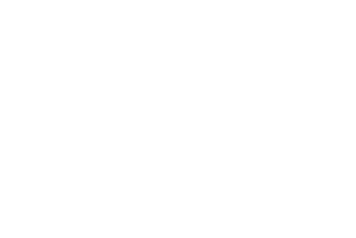

In [82]:
train_df,val_df,dsct,ctns=readWine()
args={
    'val':val_df,
    'prePruning':True,
    'method':'info_gain',
    'postPruning':False,
}
wnTree462=decisionTree(args)
wnTree462Dct=wnTree462.train(train_df,val_df,ctns,dsct)
wnTree462.predict(val_df)
print(wnTree462Dct)
createPlot(wnTree462Dct)

---
Total:  45
Correct:  20
Accuracy:  0.4444444444444444
{'Proline': {'>284.0': {'OD': {'>3.91': '0', '<=3.91': {'Hue': {'>1.56': '1', '<=1.56': {'Color.int': {'>1.51': {'Proanth': {'>3.43': '1', '<=3.43': {'Nonflavanoid.phenols': {'>0.62': '1', '<=0.62': {'Flavanoids': {'>3.84': '0', '<=3.84': {'Phenols': {'>3.46': '0', '<=3.46': {'Mg': {'>119.0': '1', '<=119.0': {'Ash': {'>2.82': '0', '<=2.82': '1'}}}}}}}}}}}}, '<=1.51': '1'}}}}}}, '<=284.0': '1'}}


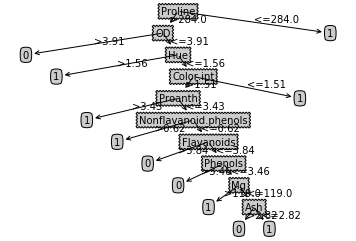

In [83]:
train_df,val_df,dsct,ctns=readWine()
args={
    'val':val_df,
    'prePruning':False,
    'method':'info_gain',
    'postPruning':True,
}
wnTree463=decisionTree(args)
wnTree463Dct=wnTree463.train(train_df,val_df,ctns,dsct)
wnTree463.predict(val_df)
print(wnTree463Dct)
createPlot(wnTree463Dct)

---
Total:  45
Correct:  29
Accuracy:  0.6444444444444445
{'Proline': {'>755.0': {'OD': {'>2.26': {'Hue': {'>1.14': {'Color.int': {'>3.15': {'Proanth': {'>1.36': {'Nonflavanoid.phenols': {'>0.25': {'Flavanoids': {'>2.66': {'Phenols': {'>2.64': {'Mg': {'>104.0': '0', '<=104.0': '0'}}, '<=2.64': '0'}}, '<=2.66': '0'}}, '<=0.25': '0'}}, '<=1.36': '0'}}, '<=3.15': '1'}}, '<=1.14': {'Acl': {'>12.8': {'Ash': {'>2.11': {'Malic.acid': {'>1.5': {'Alcohol': {'>12.89': '0', '<=12.89': '0'}}, '<=1.5': '0'}}, '<=2.11': '0'}}, '<=12.8': '0'}}}}, '<=2.26': '2'}}, '<=755.0': '1'}}


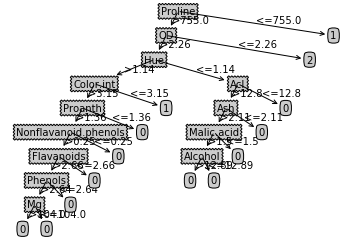

In [84]:
train_df,val_df,dsct,ctns=readWine()
args={
    'val':val_df,
    'prePruning':False,
    'method':'gini',
    'postPruning':False,
}
wnTree464=decisionTree(args)
wnTree464Dct=wnTree464.train(train_df,val_df,ctns,dsct)
wnTree464.predict(val_df)
print(wnTree464Dct)
createPlot(wnTree464Dct)

---
Total:  45
Correct:  35
Accuracy:  0.7777777777777778
{'Proline': {'>755.0': {'OD': {'>2.26': '0', '<=2.26': '2'}}, '<=755.0': {'Hue': {'>0.72': {'Color.int': {'>4.12': {'Proanth': {'>1.58': '1', '<=1.58': '2'}}, '<=4.12': '1'}}, '<=0.72': '2'}}}}


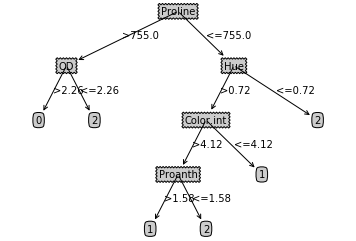

In [86]:
train_df,val_df,dsct,ctns=readWine()
args={
    'val':val_df,
    'prePruning':True,
    'method':'gini',
    'postPruning':False,
}
wnTree465=decisionTree(args)
wnTree465Dct=wnTree465.train(train_df,val_df,ctns,dsct)
wnTree465.predict(val_df)
print(wnTree465Dct)
createPlot(wnTree465Dct)

---
Total:  45
Correct:  18
Accuracy:  0.4
1


AttributeError: 'str' object has no attribute 'keys'

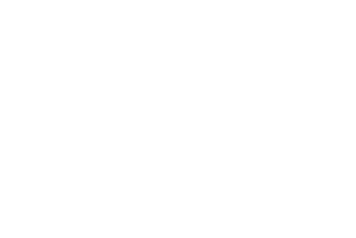

In [87]:
train_df,val_df,dsct,ctns=readWine()
args={
    'val':val_df,
    'prePruning':False,
    'method':'gini',
    'postPruning':True,
}
wnTree466=decisionTree(args)
wnTree466Dct=wnTree466.train(train_df,val_df,ctns,dsct)
wnTree466.predict(val_df)
print(wnTree466Dct)
createPlot(wnTree466Dct)

In [110]:
from scipy import stats
import numpy as np

infogain=[0.4222,0.4,0.4444,0.4,0.4,1.0,0.7143,0.4286,0.5714]
gini=[0.6444,0.7778,0.4,0.8,1.0,0.6,0.7143,0.4286,0.5714]

pre=[0.4,0.7778,0.4,1.0,0.4286,0.4286]
post=[0.4444,0.4,1.0,0.6,0.5714,0.5714]
print(stats.ttest_rel(infogain,gini))
print(stats.ttest_rel(pre,post))

Ttest_relResult(statistic=-1.2789492419939807, pvalue=0.2367639596129133)
Ttest_relResult(statistic=-0.16587115169784575, pvalue=0.874756813625647)
